<a href="https://colab.research.google.com/github/jakobatgithub/unreverb/blob/main/DetermineIRWithDenseNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install rir_generator

In [9]:
import numpy as np
import scipy.signal as ss
import soundfile as sf
import rir_generator as rir
from IPython.display import Audio 
from IPython.core.display import display
import matplotlib.pyplot as plt

# A script to generate the Impulse Response (IR) Functions of a rectangular room
# of a given size with given receiver and source positions and given Reverberation time T60.

# https://github.com/audiolabs/rir-generator
# pip install rir-generator
# pip install SoundFile

#signal, fs = sf.read("bark.wav", always_2d=True)

def my_convolution(IR_data, signal):
  #return ss.convolve(IR_data, signal, mode='full')
  return ss.convolve(signal, IR_data, mode='same')

#samplerate = 2**13
samplerate = 2**9

#reverberation_times = [0.4, 0.6, 0.8]
reverberation_times = [0.4]
IR_datas = []
idx = 0
for reverberation_time in reverberation_times:
    IR_data = rir.generate(
    	c=340,                  # Sound velocity (m/s)
    	fs=samplerate,                  # Sample frequency (samples/s)
    	r=[                     # Receiver position(s) [x y z] (m)
    	    [4.5, 2.5, 1.5]
    	],
    	s=[0.5, 2.5, 1.5],          # Source position [x y z] (m)
    	L=[5, 5, 3],            # Room dimensions [x y z] (m)
    	reverberation_time=reverberation_time, # Reverberation time T60 (s)
    	nsample=samplerate,           # Number of output samples
	)
    print(IR_data.shape)              # (4096, 3)
    IR_datas.append(IR_data)
    #sf.write('random_IRs/IRF_'+str(idx)+'.wav', IR_data, samplerate)
    idx = idx +1	

#print(signal.shape)         # (11462, 2)

# Convolve 2-channel signal with 3 impulse responses
#signal = ss.convolve(h[:, None, :], signal[:, :, None])

#print(signal.shape)         # (15557, 2, 3)

(512, 1)


In [10]:
N = samplerate
batch = 10000
split = batch
IR_data = IR_datas[0].T[0]
signal = np.random.randn(batch*N)
signals = np.array(np.array_split(signal, split))
transformed_signals = []
for signal in signals:
  transformed_signal = my_convolution(IR_data, signal)
  transformed_signals.append(transformed_signal)

transformed_signals = np.array(transformed_signals)
print(signal.shape)
print(signals.shape)
print(transformed_signal.shape)
print(transformed_signals.shape)
display(Audio(np.array(signals[0]), rate=samplerate, autoplay=False))
display(Audio(np.array(transformed_signals[0]), rate=samplerate, autoplay=False))

(512,)
(10000, 512)
(512,)
(10000, 512)


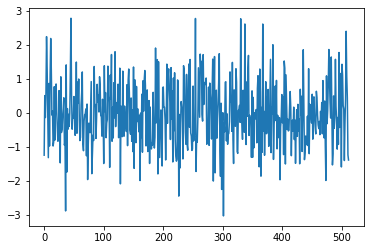

In [11]:
plt.plot(signals[0])
plt.show()

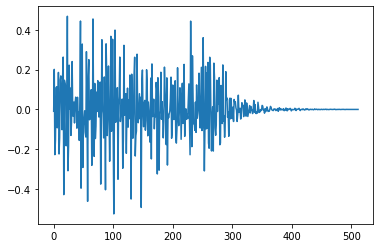

In [13]:
plt.plot(transformed_signals[0])
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               262144    
                                                                 
Total params: 262,144
Trainable params: 262,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/35
100/100 [==============================] - 1s 2ms/step - loss: 0.4480
Epoch 2/35
100/100 [==============================] - 0s 2ms/step - loss: 0.0321
Epoch 3/35
100/100 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 4/35
100/100 [==============================] - 0s 2ms/step - loss: 1.9940e-05
Epoch 5/35
100/100 [==============================] - 0s 2ms/step - loss: 2.1011e-07
Epoch 6/35
100/100 [==============================] - 0s 2ms/step - loss: 1.4578e-09
Epoch 7/35
100/100 [==============================] - 0s 2ms/step - loss: 7.8367

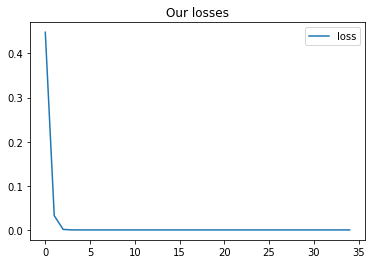

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Convolution1D

X = signals
y = transformed_signals

# Create model with no hidden layers, same number of outputs as inputs.
# No bias needed.  No activation function, 
# since DFT is linear.
model = Sequential([Dense(transformed_signals.shape[1], input_dim=N, use_bias=False, activation=None)])
#model = Sequential([Convolution1D(N, kernel_size=N, padding='causal', input_shape=(None, 256), dilation_rate=1, use_bias=False, activation=None)])
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X, y, epochs=35, batch_size=100, verbose='auto')
print(f"history.history['loss'][-1]: {history.history['loss'][-1]}")
render_history(history.history)

In [16]:
datas = np.random.randn(2,N)
transformed_datas = []
for data in datas:
  transformed_data = my_convolution(IR_data, data)
  transformed_datas.append(transformed_data)

prediction = model.predict(datas)
print(f'Convolution matches NN: {np.allclose(prediction, transformed_datas, rtol=1e-02)}')

Convolution matches NN: True


In [17]:
prediction - transformed_datas

array([[ 5.48140971e-08, -9.66516341e-08,  5.78120160e-09, ...,
         2.58252686e-10, -9.54785789e-11,  2.31862066e-12],
       [-4.96196143e-09,  2.26937526e-08,  5.33242707e-08, ...,
        -8.86186177e-12,  3.02975926e-11,  5.27417677e-11]])

In [3]:
N = samplerate
batch = 10000
split = batch
IR_data = IR_datas[0].T[0]
signal = np.random.randn(batch*N)
signals = np.array(np.array_split(signal, split))
transformed_signal = ss.convolve(signal, IR_data, mode='same')
#transformed_signal = ss.convolve(IR_data, signal)
transformed_signal = transformed_signal[:N*batch]
transformed_signals = np.array(np.array_split(transformed_signal, split))
print(signal.shape)
print(signals.shape)
print(transformed_signal.shape)
print(transformed_signals.shape)
display(Audio(np.array(signals[0]), rate=samplerate, autoplay=False))
display(Audio(np.array(transformed_signals[0]), rate=samplerate, autoplay=False))

(5120000,)
(10000, 512)
(5120000,)
(10000, 512)


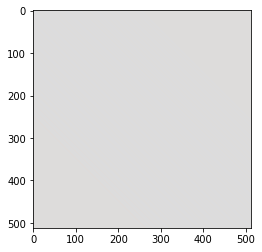

In [32]:
plt.imshow(model.get_weights()[0], vmin=-1, vmax=1, cmap='coolwarm')

In [8]:
2**(2*9)

262144

In [5]:
2**5

32

In [ ]:
"""
Train a neural network to implement the discrete Fourier transform
"""
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

N = 2**5
batch = 10000

def render_history(history):
    plt.plot(history["loss"], label="loss")
    #plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

# Generate random input data and desired output data
sig = np.random.randn(batch, N) + 1j*np.random.randn(batch, N)
F = np.fft.fft(sig, axis=-1)

# First half of inputs/outputs is real part, second half is imaginary part
X = np.hstack([sig.real, sig.imag])
Y = np.hstack([F.real, F.imag])

# Create model with no hidden layers, same number of outputs as inputs.
# No bias needed.  No activation function, since DFT is linear.
model = Sequential([Dense(N*2, input_dim=N*2, use_bias=False)])
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X, Y, epochs=100, batch_size=100, verbose='auto')

render_history(history.history)

# Confirm that it works
data = np.arange(N)


def ANN_DFT(x):
    if len(x) != N:
        raise ValueError(f'Input must be length {N}')
    pred = model.predict(np.hstack([x.real, x.imag])[np.newaxis])[0]
    result = pred[:N] + 1j*pred[N:]
    return result


ANN = ANN_DFT(data)
FFT = np.fft.fft(data)
print(f'ANN matches FFT: {np.allclose(ANN, FFT)}')

# Heat map of neuron weights
plt.imshow(model.get_weights()[0], vmin=-1, vmax=1, cmap='coolwarm')

In [7]:
history.history["loss"][-1]

7.425119546988768e-13

In [12]:
from IPython.display import Audio 
from IPython.core.display import display
def beep():
    sr = 2**13 # sample rate
    T = 0.5    # seconds
    t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
    signal = 0.5*np.sin(2*np.pi*440*t)              # pure sine wave at 440 Hz
    display(Audio(signal, rate=sr, autoplay=False))
    tranformed_signal = ss.convolve(IR_data, signal, mode='full')
    display(Audio(tranformed_signal, rate=sr, autoplay=False))
beep();